In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
fs = pd.read_parquet(r"C:\Users\vnsp8460\Desktop\Johnny_folder\flash_sale\fs_uplift_0527_fts.parquet")
preds = pd.read_csv(r"C:\Users\vnsp8460\Desktop\Johnny_folder\flash_sale\preds_0527_v2.csv")

In [48]:
preds.rename(columns={
    'model_price':'order_price_pp',
    'time_frame':'fs_time_frame'},inplace=True)

In [49]:
# Add uplift score to fs
fs = fs.merge(
    preds, 
    on=[
    "item_id",
    "model_id",
    "item_name", 
    "order_price_pp",
    "fs_time_frame",
    "item_price_before_discount_pp"
    ],
    how="inner") 

In [50]:
# Establish lower and upper bounds
quartiles = np.quantile(fs["uplift_score"], [0,0.05,0.25,0.5,0.75,0.95,1])

low_arg = 0.05
high_arg = 0.95

lower = np.quantile(fs["uplift_score"], low_arg)
upper = np.quantile(fs["uplift_score"], high_arg)

<Axes: xlabel='uplift_score', ylabel='Count'>

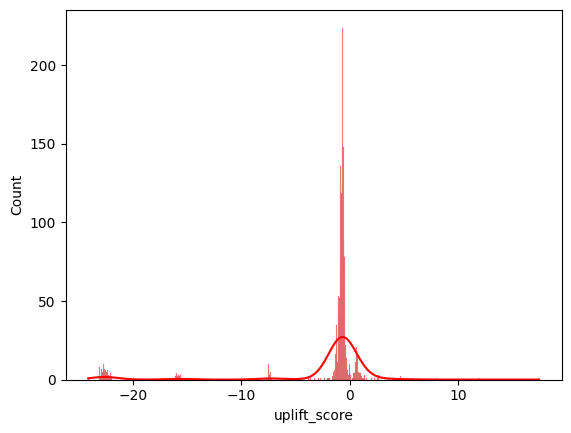

In [ ]:
# Distribution before removing outliers
# sns.histplot(data=fs, x="uplift_score", kde=True, color="red")

In [51]:
# Remove outliers
fs2 = fs[
    (fs["uplift_score"] > lower) &
    (fs["uplift_score"] < upper)
    ].copy()

In [52]:
# Establish performance
def performance(item_uplift, arg1, arg2):
    if item_uplift > arg2:
        return "high-performer"
    elif item_uplift < arg1:
        return "low-performer"
    else:
        return "mid-performer"

arg1 = np.quantile(fs2["uplift_score"], 0.10)
arg2 = np.quantile(fs2["uplift_score"], 0.90)

fs2["performance"] = fs2["uplift_score"].apply(performance, args=(arg1,arg2)) 

<Axes: xlabel='uplift_score', ylabel='Count'>

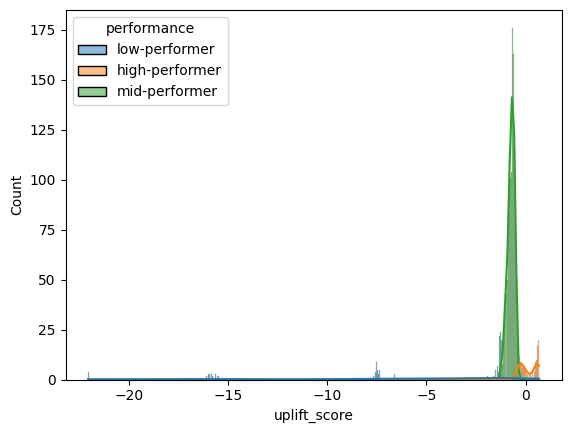

In [8]:
# Distribution after outlier removal
sns.histplot(data=fs2, x="uplift_score", kde=True, color="red", hue='performance')

In [ ]:
#fs2[
#    fs2.select_dtypes(include=['int', 'float'])
#    .columns.tolist()].corr(method='pearson')['uplift_score'].reset_index(name='pearson_correlation_score')

In [53]:
# Function to perform scatterplots on different variables

def scatter_no_agg(independent_var, ax):
    sns.regplot(
        data=fs2,
        y=independent_var,
        x='uplift_score',
        ci=None,
        line_kws={'color': 'gold'},
        ax=ax
    )
    ax.set_title(f'uplift_score vs {independent_var}')
    
def scatter(independent_var, ax):
    temp = fs2.groupby(independent_var)['uplift_score'].mean().reset_index(name='uplift_mean')
    sns.regplot(
        data=temp,
        x='uplift_mean',
        y=independent_var,
        ci=None,
        line_kws={'color': 'gold'},
        ax=ax
    )
    ax.set_title(f'uplift_mean vs {independent_var}')

In [233]:
# Variables with the most significant Spearman's correlation score
#variable_list = ['sr_ads_pdp_view_cnt_model','total_cmt_l20d','days_since_first_sale','rating_l20d']

#fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
#axes = axes.flatten()  

#for i, var in enumerate(variable_list):
#    scatter(var, axes[i])

#plt.tight_layout()
#plt.show()

In [61]:
numerical = [
    'fs_stock_cnt',
    'order_price_pp',
    'days_since_first_sale',
    #'total_pdp_view_cnt_model',
    'sr_ads_pdp_view_cnt_model',
    'sr_non_ads_pdp_view_cnt_model',
    'cart_view_cnt_model',
    #'fs_hour_start',
    #'fs_hour_end',
    'fs_duration',
    'total_cmt_l20d',
    #'rating_l20d'
]

fs3 = fs2.dropna(subset=numerical + ['uplift_score'])

#fs3 = pd.get_dummies(fs3, columns=['level1_global_be_category'], drop_first=True)

In [ ]:
# 
numerical = [
    'fs_stock_cnt',
    'order_price_pp',
    'days_since_first_sale',
    #'total_pdp_view_cnt_model',
    'sr_ads_pdp_view_cnt_model',
    'sr_non_ads_pdp_view_cnt_model',
    'cart_view_cnt_model',
    #'fs_hour_start',
    #'fs_hour_end',
    'fs_duration',
    'total_cmt_l20d',
    #'rating_l20d',
    'level1_global_be_category_Automobiles',
    'level1_global_be_category_Baby & Kids Fashion',
    'level1_global_be_category_Beauty',
    'level1_global_be_category_Computers & Accessories',
    'level1_global_be_category_Fashion Accessories',
    'level1_global_be_category_Food & Beverages',
    'level1_global_be_category_Health',
    'level1_global_be_category_Hobbies & Collections',
    'level1_global_be_category_Home & Living',
    'level1_global_be_category_Home Appliances',
    'level1_global_be_category_Men Bags',
    'level1_global_be_category_Men Clothes',
    'level1_global_be_category_Men Shoes',
    'level1_global_be_category_Mobile & Gadgets',
    'level1_global_be_category_Mom & Baby',
    'level1_global_be_category_Pets',
    'level1_global_be_category_Sports & Outdoors',
    'level1_global_be_category_Stationery',
    'level1_global_be_category_Travel & Luggage',
    'level1_global_be_category_Women Bags',
    'level1_global_be_category_Women Clothes',
    'level1_global_be_category_Women Shoes'    
]

X = fs3[numerical]
y = fs3['uplift_score']

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict 
y_pred = model.predict(X_test)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': numerical,
    'Coefficient': model.coef_
})

coefficients

In [66]:
import statsmodels.formula.api as smf

model = smf.ols(
    '''
    uplift_score~
    fs_stock_cnt+
    order_price_pp+
    days_since_first_sale+
    sr_ads_pdp_view_cnt_model+
    sr_non_ads_pdp_view_cnt_model+
    cart_view_cnt_model+
    fs_duration+
    total_cmt_l20d+
    C(level1_global_be_category)
    '''
    ,data=fs3).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           uplift_score   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     2.369
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           5.30e-05
Time:                        17:10:00   Log-Likelihood:                -2337.0
No. Observations:                1107   AIC:                             4736.
Df Residuals:                    1076   BIC:                             4891.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

Scatterplots without aggregation (generates a lot of noise)

In [ ]:
numerical_list = [
    'fs_stock_cnt',
    'order_price_pp',
    'days_since_first_sale',
    'total_pdp_view_cnt_model',
    'sr_ads_pdp_view_cnt_model',
    'sr_non_ads_pdp_view_cnt_model',
    'cart_view_cnt_model',
    'fs_hour_start',
    'fs_hour_end',
    'fs_duration',
    'total_cmt_l20d',
    'rating_l20d'
    ]

fig, axes = plt.subplots(4, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, var in enumerate(numerical_list):
    scatter_no_agg(var, axes[i])

plt.tight_layout()
plt.show()

Scatterplots with aggregation (less noise)

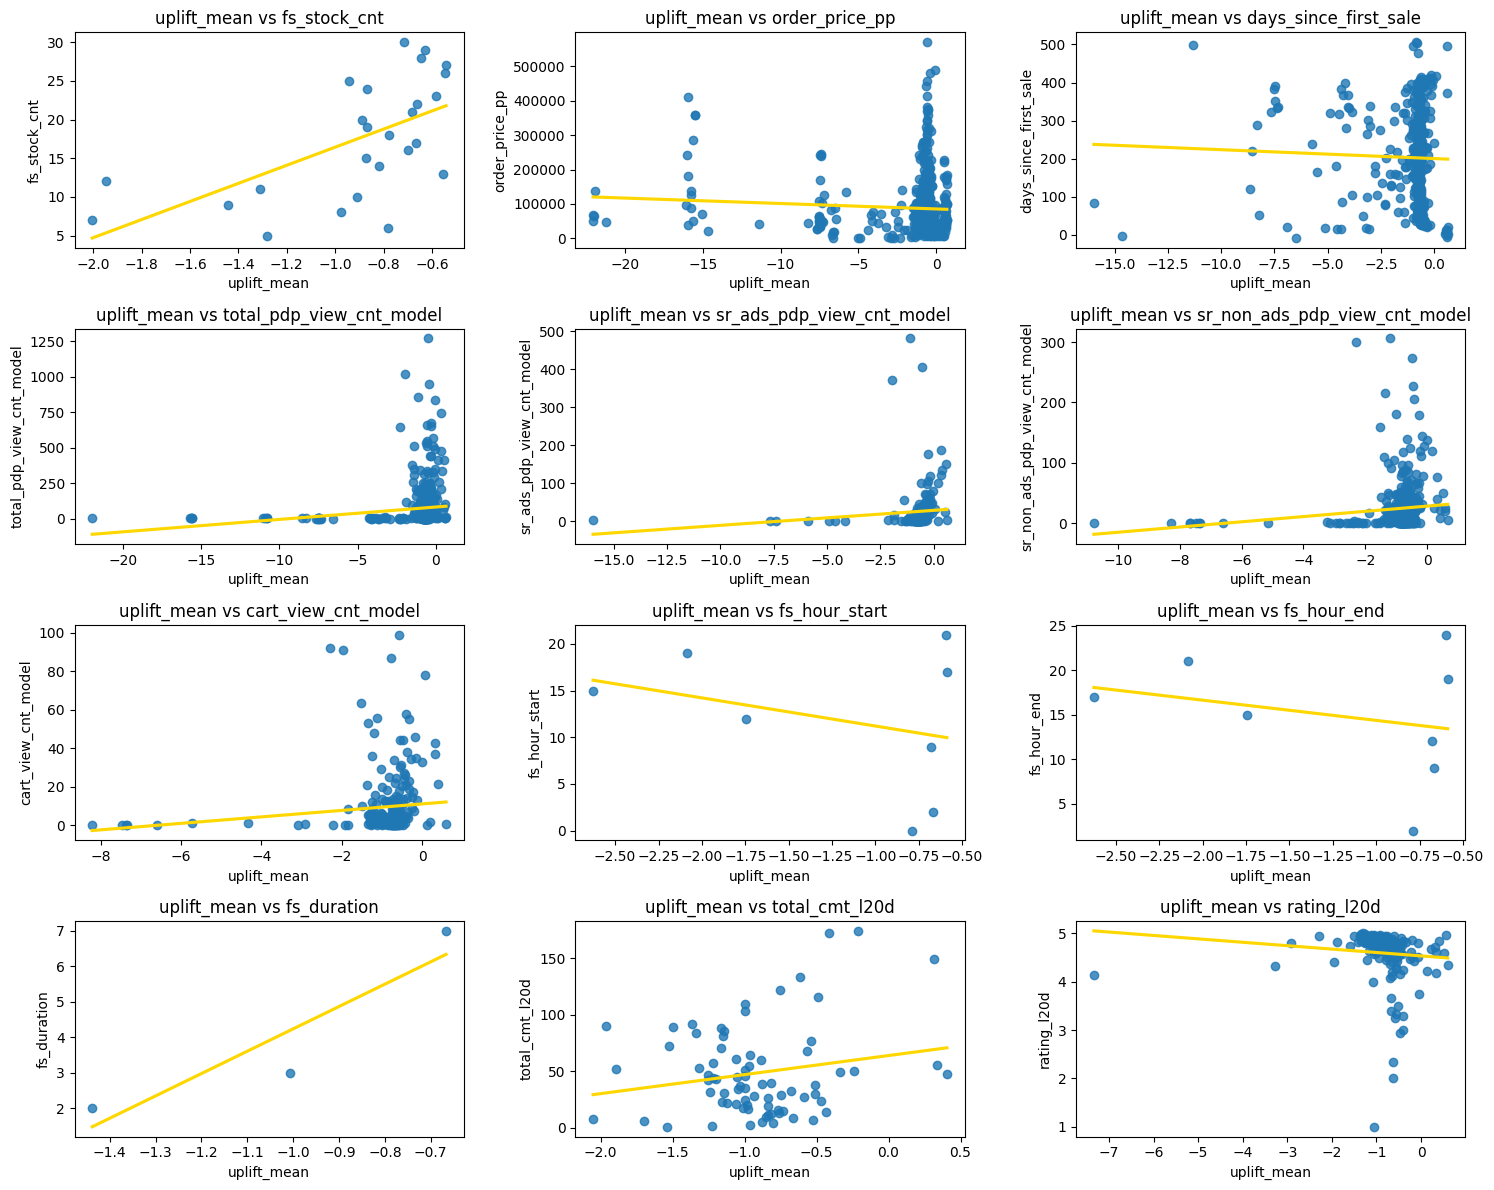

In [234]:
numerical_list = [
    'fs_stock_cnt',
    'order_price_pp',
    'days_since_first_sale',
    'total_pdp_view_cnt_model',
    'sr_ads_pdp_view_cnt_model',
    'sr_non_ads_pdp_view_cnt_model',
    'cart_view_cnt_model',
    'fs_hour_start',
    'fs_hour_end',
    'fs_duration',
    'total_cmt_l20d',
    'rating_l20d'
    ]

fig, axes = plt.subplots(4, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, var in enumerate(numerical_list):
    scatter(var, axes[i])

plt.tight_layout()
plt.show()

Analysis on categorical columns

In [ ]:
# Summary for each category
def summarize_category(x):
    count = []
    count = pd.DataFrame(fs2.groupby(x)[x].count())
    count.rename(columns={x:"total_count"}, inplace=True)

    fs2_high = fs2[fs2["performance"]=="high-performer"]

    high_count = []
    high_count = pd.DataFrame(fs2_high.groupby(x)[x].count())
    high_count.rename(columns={x:"high_count"}, inplace=True)

    uplift_mean = []
    uplift_mean = pd.DataFrame(fs2.groupby(x)["uplift_score"].mean())
    uplift_mean.rename(columns={"uplift_score":"uplift_mean"}, inplace=True)

    high_count = high_count.merge(
    count,
    on=x,
    how="inner"
    )

    high_count = high_count.merge(
    uplift_mean,
    on=x,
    how="inner"
    )

    category_summary = high_count.copy()
    category_summary["high/total"] = category_summary["high_count"]/category_summary["total_count"]

    return category_summary

In [ ]:
#categorical_list = fs2.select_dtypes(include=['object']).columns.tolist()

temp = summarize_category('level1_global_be_category').sort_values(by='uplift_mean',ascending=False).reset_index()
#temp.to_csv('1.csv',index=False)
#temp

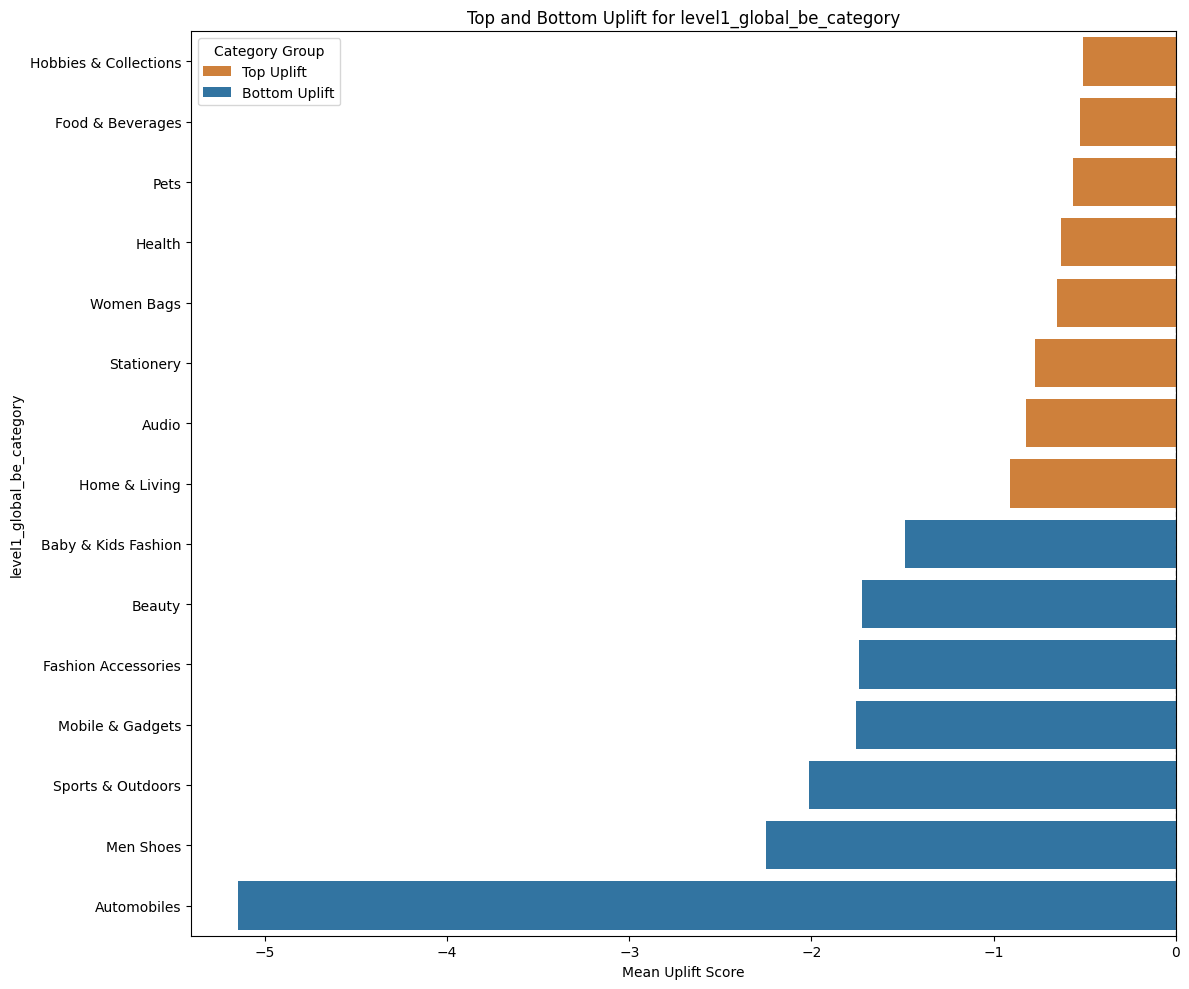

In [ ]:
# Barplots
def barplot(category):
    temp = summarize_category(category)
    top = temp.sort_values('uplift_mean', ascending=False).head(8)
    bottom = temp.sort_values('uplift_mean').head(7)

    top['Group'] = 'Top Uplift'
    bottom['Group'] = 'Bottom Uplift'

    combined = pd.concat([top, bottom])

    # Sort in descending order so highest is at the top
    combined_sorted = combined.sort_values('uplift_mean', ascending=False)

    # Custom colors for each group
    custom_palette = {
        'Top Uplift': '#e67e22',     # orange
        'Bottom Uplift': '#1f77b4'   # blue
    }

    # Plot single barplot
    plt.figure(figsize=(12, 10))
    sns.barplot(
        data=combined_sorted,
        x='uplift_mean',
        y=category,
        hue='Group',
        dodge=False,
        palette=custom_palette
    )

    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f'Top and Bottom Uplift for {category}')
    plt.xlabel('Mean Uplift Score')
    plt.ylabel(category)
    plt.legend(title='Category Group')
    plt.tight_layout()
    plt.show()

barplot('level1_global_be_category')

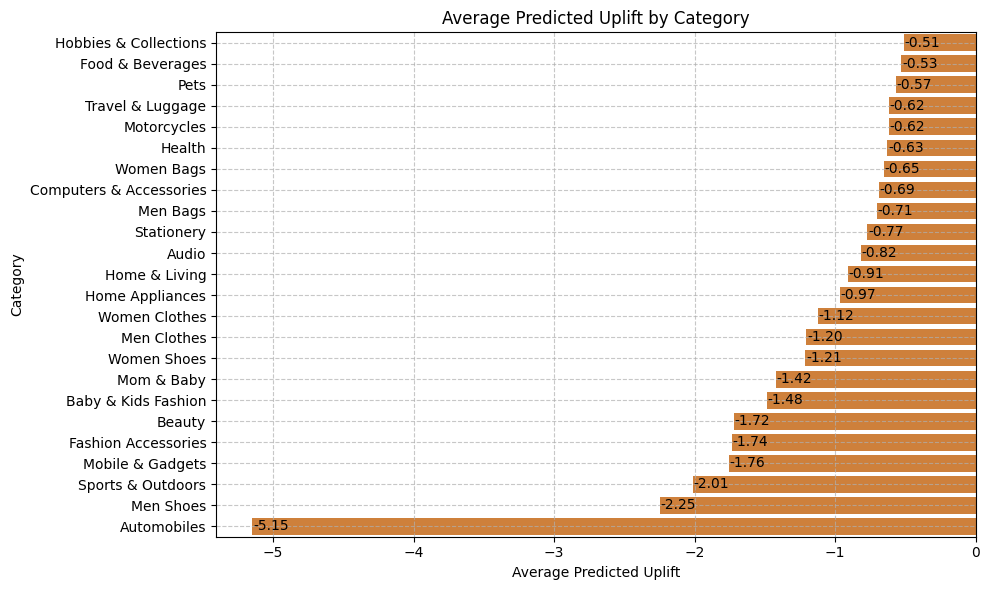

In [8]:
temp = fs2.groupby('level1_global_be_category')['uplift_score'].mean().reset_index(name='uplift_score')

temp = temp.sort_values(by='uplift_score', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=temp,
    x='uplift_score',
    y='level1_global_be_category',
    dodge=False,
    color='#e67e22'
)

for patch in ax.patches:
    width = patch.get_width()
    y = patch.get_y() + patch.get_height() / 2
    ax.text(
        width + 0.005, 
        y,
        f'{width:.2f}',  
        va='center',
        ha='left',
        fontsize=10
    )

plt.xlabel('Average Predicted Uplift')
plt.ylabel('Category')
plt.title('Average Predicted Uplift by Category')
plt.grid(
    True, 
    #axis='x',
    linestyle='--', 
    alpha=0.7
    )
plt.tight_layout()
plt.show()

In [ ]:
# Create a table with both level 1 & 2 categories
level_mean = fs2.groupby([
    'level1_global_be_category',
    'level2_global_be_category',
    ])['uplift_score'].mean().reset_index(name='uplift_mean')

level_count = fs2.groupby([
    'level1_global_be_category',
    'level2_global_be_category',
    ])[[
        'level1_global_be_category',
        'level2_global_be_category',
        ]].value_counts().reset_index(name='count')

level_df = level_count.merge(level_mean,on=['level1_global_be_category','level2_global_be_category'],how='inner')

level_high_count = fs2[fs2['performance']=='high-performer'].groupby([
    'level1_global_be_category',
    'level2_global_be_category',
    ])[[
        'level1_global_be_category',
        'level2_global_be_category',
        ]].value_counts().reset_index(name='count')

level_df = level_df.merge(level_high_count,on=['level1_global_be_category','level2_global_be_category'],how='left')

level_df.rename(columns={'count_x':'total_count','count_y':'high_count'}, inplace=True)

level_df['high_count'] = level_df['high_count'].fillna(0)

level_df['high/total'] = level_df['high_count'] / level_df['total_count']

level_df = level_df[[
    'level1_global_be_category',
    'level2_global_be_category',
    'high_count',
    'total_count',
    'uplift_mean',
    'high/total']]

#level_df.to_csv('level1&2_category2.csv',index=False)

level_df

,level1_global_be_category,level2_global_be_category,high_count,total_count,uplift_mean,high/total
0,Audio,"Earphones, Headphones & Headsets",2.0,12,-1.015937,0.166667
1,Audio,Home Audio & Speakers,1.0,7,-0.564759,0.142857
2,Audio,Microphones,0.0,2,-0.531456,0.000000
3,Automobiles,Automobile Exterior Accessories,0.0,1,-7.227934,0.000000
4,Automobiles,Automobile Interior Accessories,1.0,2,-11.090010,0.500000
...,...,...,...,...,...,...
120,Women Shoes,Flat Sandals & Flip Flops,4.0,32,-1.764189,0.125000
121,Women Shoes,Flats,6.0,44,-0.728065,0.136364
122,Women Shoes,Heels,1.0,29,-1.387956,0.034483
123,Women Shoes,Sneakers,0.0,2,-0.695075,0.000000


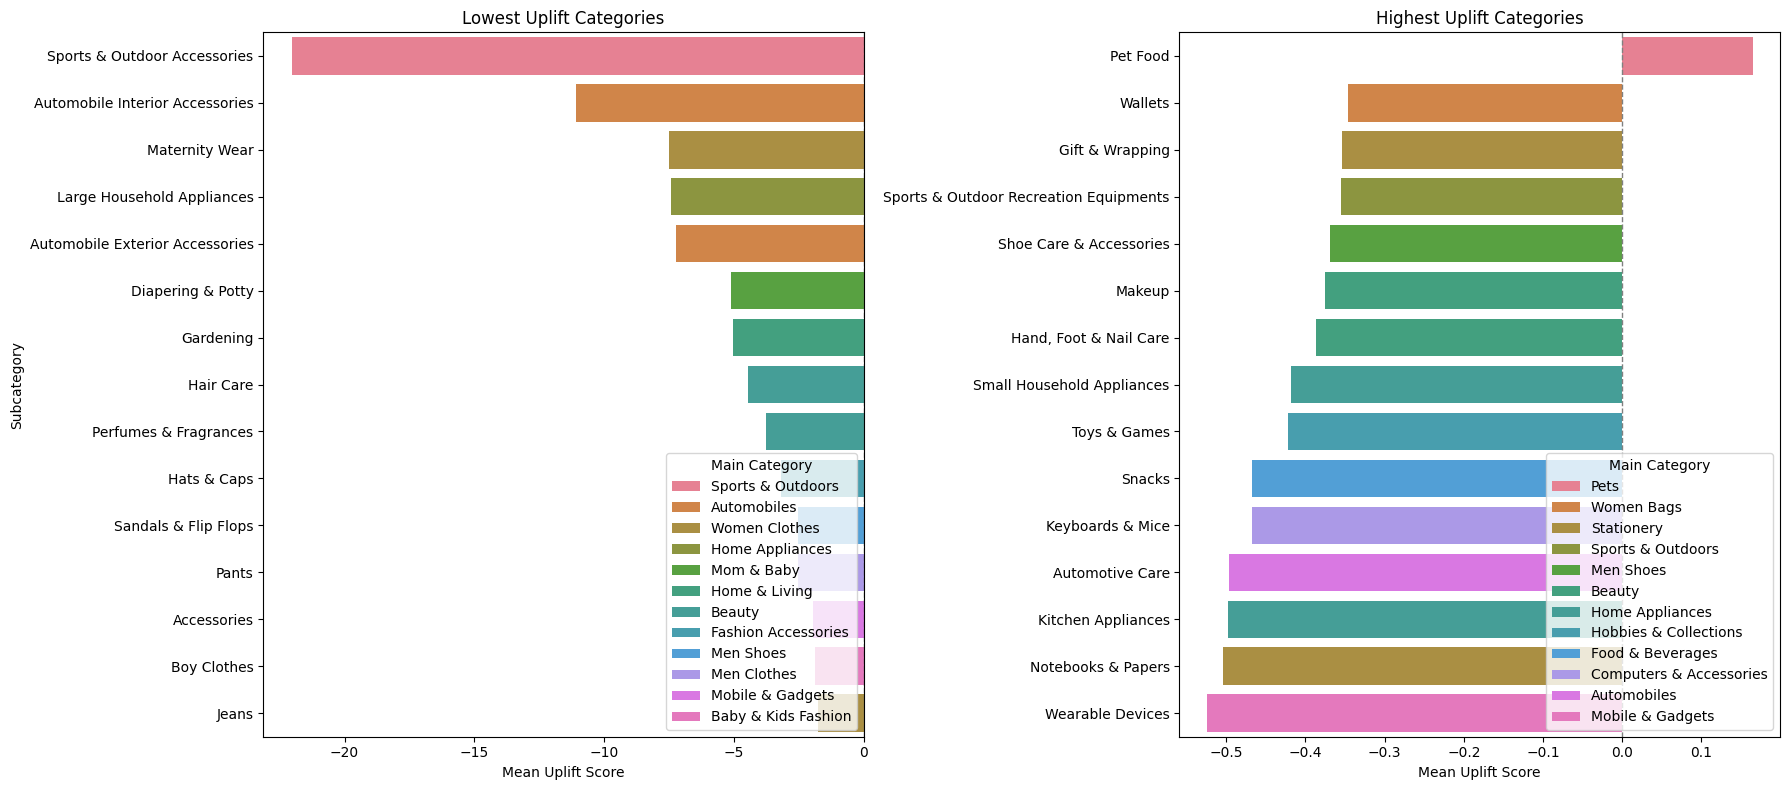

In [ ]:
# Graph the above table
top = level_df.sort_values('uplift_mean', ascending=False).head(15)
bottom = level_df.sort_values('uplift_mean').head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=False)

sns.barplot(
    data=bottom,
    x='uplift_mean',
    y='level2_global_be_category',
    hue='level1_global_be_category',
    dodge=False,
    ax=axes[0]
)
axes[0].set_title('Lowest Uplift Categories')
axes[0].set_xlabel('Mean Uplift Score')
axes[0].set_ylabel('Subcategory')

sns.barplot(
    data=top,
    x='uplift_mean',
    y='level2_global_be_category',
    hue='level1_global_be_category',
    dodge=False,
    ax=axes[1]
)
axes[1].set_title('Highest Uplift Categories')
axes[1].set_xlabel('Mean Uplift Score')
axes[1].set_ylabel('')

for ax in axes:
    ax.legend(title='Main Category', loc='lower right')
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()